In [1]:
import torch
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# read data here
directory = "/home/tgbergendahl/research/NLP/data/archive/"
filename = "airbnb-listings.csv"
full_path = directory + filename

df = pd.read_csv(full_path, sep=';', nrows=500000)
x = len(df)
print(f"Read in {x} values")

/tmp/ipykernel_975/1383703803.py:6: DtypeWarning: Columns (0,2,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep=';', nrows=500000)


Read in 494954 values


In [4]:
df = df[['ID', 'Summary', 'Price']]
df = df[df['Price']>0]
x = len(df)
print(f"Filtering out price=0 results in {x} values")
df = df[pd.notna(df['Summary'])]
x = len(df)
print(f"Filtering out N/A Summaries results in {x} values")

Filtering out price=0 results in 486974 values
Filtering out N/A Summaries results in 471089 values


In [5]:
df.head()

,ID,Summary,Price
0,4008728,‪This luxurious apartment is situated in the c...,600.0
1,7778612,"Beautiful, large (105m2, 2 floors) and quiet a...",175.0
2,8264596,This central located apartment will make you f...,125.0
3,2180729,Living like an Amsterdam resident in this ligh...,130.0
4,14463171,Studio Apartment Centre Amsterdam Perfect stud...,80.0


In [6]:
mean_len = df['Summary'].apply(len).mean()

mean_len

280.6828051599592

In [7]:
sentences = df.Summary.values
targets = df.Price.values

In [8]:
import random

# split into train, test, val
samples = len(df)

indices = [i for i in range(samples)]
random.shuffle(indices)

train_indices = indices[:round(0.6*samples)]
val_indices = indices[round(0.6*samples):round(0.8*samples)]
test_indices = indices[round(0.8*samples):]

In [9]:
from transformers import BertTokenizer, BertModel, AdamW

model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

/home/tgbergendahl/miniconda3/envs/NLP/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
input_ids = []
attention_masks = []

max_sentence_length = 512

for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_sentence_length,
        truncation=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors = 'pt',
    )

    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
outputs = torch.tensor(targets, dtype=torch.float32)

/home/tgbergendahl/miniconda3/envs/NLP/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
from torch.utils.data import TensorDataset, Subset, DataLoader

dataset = TensorDataset(input_ids, attention_masks, outputs)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [12]:
batch_size = 64

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
)

val_dataloader = DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=batch_size,
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=batch_size,
)

In [13]:
import torch.nn as nn

class BertForSequenceRegression(nn.Module):
    def __init__(self, model_name, output_size):
        super(BertForSequenceRegression, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)

        self.out = nn.Linear(768, output_size)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = output.last_hidden_state
        output = output[:,0,:]
        output=self.out(output)
        return output

In [14]:
model = BertForSequenceRegression(model_name, output_size=1)

for i in range(0, 10):
    for param in model.bert.parameters(i):
        param.requires_grad = False

model = model.to(device)

In [15]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20

criterion = torch.nn.MSELoss()

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i+1, epochs))
    print("Training...")

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print(" Batch {:>5,} of {:>5,}. Elapsed: {:}.".format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # optimizer.zero_grad()
        model.zero_grad()

        output = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        loss = criterion(output.view(-1), b_labels.view(-1))

        total_train_loss += loss.item()

        loss.backward()

        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print(" Average training loss: {0:.2f}".format(avg_train_loss))
    print(" Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(input_ids=b_input_ids, attention_mask=b_input_mask)

        loss = criterion(output.view(-1), b_labels.view(-1))

        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(val_dataloader)

    validation_time = format_time(time.time()-t0)

    print(" Validation Loss: {0:.2f}".format(avg_val_loss))
    print(" Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
            'Validation Loss': avg_val_loss,
            'Validation Time': validation_time
        }
    )

print("")
print("Training Completed!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...
 Batch    40 of 4,417. Elapsed: 0:00:54.
 Batch    80 of 4,417. Elapsed: 0:01:47.
 Batch   120 of 4,417. Elapsed: 0:02:40.
 Batch   160 of 4,417. Elapsed: 0:03:32.
 Batch   200 of 4,417. Elapsed: 0:04:27.
 Batch   240 of 4,417. Elapsed: 0:05:19.
 Batch   280 of 4,417. Elapsed: 0:06:12.
 Batch   320 of 4,417. Elapsed: 0:07:05.
 Batch   360 of 4,417. Elapsed: 0:08:00.
 Batch   400 of 4,417. Elapsed: 0:08:52.
 Batch   440 of 4,417. Elapsed: 0:09:45.
 Batch   480 of 4,417. Elapsed: 0:10:38.
 Batch   520 of 4,417. Elapsed: 0:11:30.
 Batch   560 of 4,417. Elapsed: 0:12:25.
 Batch   600 of 4,417. Elapsed: 0:13:17.
 Batch   640 of 4,417. Elapsed: 0:14:10.
 Batch   680 of 4,417. Elapsed: 0:15:03.
 Batch   720 of 4,417. Elapsed: 0:15:58.
 Batch   760 of 4,417. Elapsed: 0:16:51.
 Batch   800 of 4,417. Elapsed: 0:17:44.
 Batch   840 of 4,417. Elapsed: 0:18:36.
 Batch   880 of 4,417. Elapsed: 0:19:29.
 Batch   920 of 4,417. Elapsed: 0:20:24.
 Batch   960 

In [ ]:
import os

directory = "/home/tgbergendahl/research/NLP/models"
filename = "bert_regressor_finetuned"
full_path = directory + "/" + filename

if not os.path.exists(directory):
    os.makedirs(directory)

torch.save(model.state_dict(), full_path)

In [ ]:
pd.set_option('display.precision', 4)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

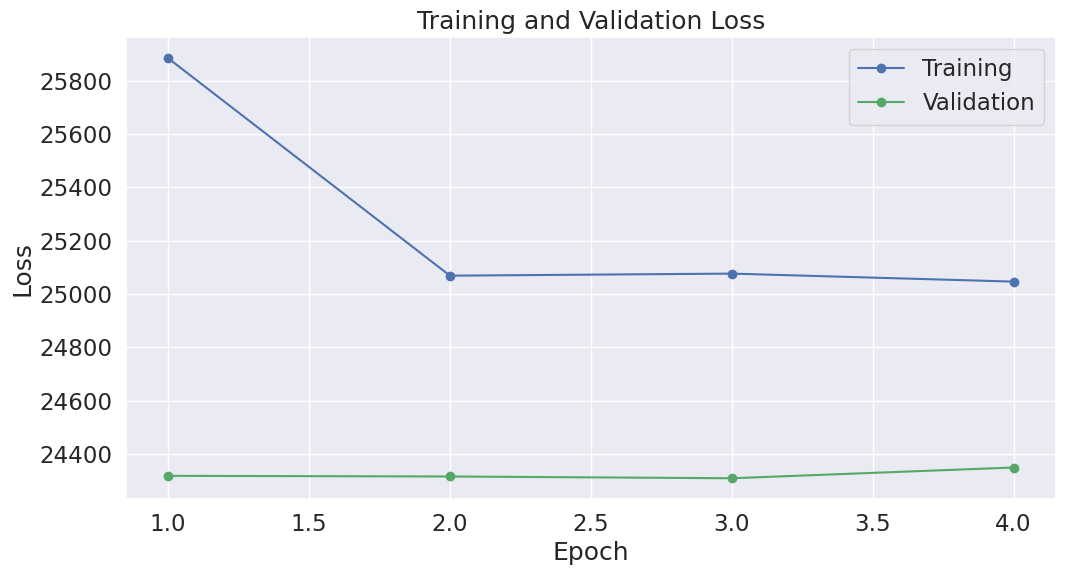

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

directory = "/home/tgbergendahl/research/NLP/data_figures/10_23_24"
filename = "train_val_loss.png"
full_path = directory + "/" + filename

if not os.path.exists(directory):
    os.makedirs(directory)

plt.savefig(full_path)

In [ ]:
print("Predicting values for {:,} test sentences...".format(len(test_dataloader.dataset)))

model.eval()
predictions = []
truths = []

total_test_loss = 0

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        output = model(b_input_ids, b_input_mask)

    predictions.append(output)
    truths.append(b_labels)

    loss = criterion(output.view(-1), b_labels.view(-1))

    total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(test_dataloader)

print(avg_test_loss)
print(" DONE")

Predicting values for 1,899 test sentences...
27074.20821707589
 DONE


In [ ]:
import numpy as np

truths_list = []
for truth_vector in truths:
    for value in truth_vector:
        truths_list.append(value.item())
truths_array = np.array(truths_list)

pred_list = []
for pred_vector in predictions:
    for value in pred_vector:
        pred_list.append(value.item())
pred_array = np.array(pred_list)

In [ ]:
pred_array = pred_array.reshape(-1)
truths_array = truths_array.reshape(-1)

In [ ]:
res_df = pd.DataFrame(
    {
        'ground_truth': truths_array,
        'predictions': pred_array,
    }
)

In [ ]:
res_df

,ground_truth,predictions
0,360.0,133.4932
1,68.0,133.4932
2,848.0,133.4932
3,550.0,133.4932
4,110.0,133.4932
...,...,...
1894,125.0,133.4932
1895,59.0,133.4932
1896,65.0,133.4932
1897,55.0,133.4932


In [ ]:
res_df.describe()

,ground_truth,predictions
count,1899.0000,1.8990e+03
mean,145.0779,1.3349e+02
std,164.3586,8.1487e-06
min,1.0000,1.3349e+02
25%,50.0000,1.3349e+02
50%,90.0000,1.3349e+02
75%,152.0000,1.3349e+02
max,999.0000,1.3349e+02
